In [3]:
import math
import lmfit
import json
import os
import numpy as np
import pandas as pd
from pandas import Series
from scipy import optimize
from matplotlib import ticker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.optimize import leastsq

In [2]:
def union_data(x_data, y_data, posi):
    """
    间隔为0.2
    """
    interval = 0.2
    X = []
    Y = []
    if posi == 1:
        x_y = {round(i, 1): [] for i in np.arange(0, 6.4 + interval, interval)}
    elif posi == -1:
        x_y = {round(i, 1): [] for i in np.arange(-8.0, interval, interval)}
    
    for x, y in zip(x_data, y_data):
        k = round(int(x / interval) * interval, 1) # 取 interval
        try:
            x_y[k].append(y)
        except:
            pass
    
    for x in x_y:
        y_list = x_y[x]
        if y_list:
            y = np.array(y_list).mean()
        else:
            y = -1
#         x_y[x] = y
        X.append(x)
        Y.append(y)
    
    last = 10000
    for i in range(len(Y)): 
        if Y[i] != -1:
            last = Y[i]
        if Y[i] == -1: # 找到第一个0
            for j in range(i+1, len(Y)): 
                if Y[j] != -1: # 找到最近的一个非0
                    now = Y[j]
                    break
            else:
                for m in range(i, len(Y)):
                    Y[m] = last
                return X, Y

            gap = (now - last) / (j - i + 1)
            for k in range(i, j):
                Y[k] = last + gap * (k - i + 1)
    return X, Y


def my_line(x_n, y_n, x, y, **kw):
    '''
    牛熊市下用户行为的差异
    :param x_n: 收益率小于0
    :param y_n:
    :param x: 收益率大于0
    :param y:
    :return:
    '''

    def linear(input_x, input_y):
        '''
        线性回归
        :param x:
        :param y:
        :return: 拟合参数
        '''
        clf = LinearRegression()
        X = [[i] for i in input_x.tolist()]
        y = input_y.tolist()
        clf.fit(X, y)
        return clf.coef_[0], clf.intercept_, clf.score(X, y)
    
    def liner_model(k, b):
        def model(x):
            return b + k * x
        return model
    
    
    res = {}
    plt.figure(figsize=(12, 5))
    
    plt.scatter(x_n, y_n, alpha=0.3, label='$r < 0$')
    plt.scatter(x, y, alpha=0.3, label='$r > 0$')
    
    union_x_n, union_y_n = union_data(x_n, y_n, posi=-1)
    union_x, union_y = union_data(x, y, posi=1)
    plt.plot(union_x_n, union_y_n, c='grey')
    plt.plot(union_x, union_y, c='grey')
    
    
    # 正
    print('return > 0')
    
    # 画拟合直线
    print('---------- 收益率 < 0 ----------')
    a_n, b_n, r2 = linear(x_n, y_n)
    print('相关性：', x_n.corr(y_n))
    print('参数：', a_n, b_n)
    res['k_n'] = a_n
    res['b_n'] = b_n
    print('R^2：', r2)
    mod_n = liner_model(a_n, b_n)
    p_0 = mod_n(0)
    p_8 = mod_n(-8)
    p_4 = mod_n(4)
    plt.plot([-8, 0], [p_8, p_0], '-', c='purple', linewidth=2)
    plt.plot([0, 4], [p_0, p_4], 'r--', linewidth=2)
    
    pars = lmfit.Parameters()
    pars.add_many(('k', 1000), ('b', 1000))
    def residual(p):
        return p['k'] * x_n + p['b'] - y_n

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))

    print('---------- 收益率 > 0 ----------')
    a, b, r2 = linear(x, y)
    print('相关性：', x.corr(y))
    print('参数：', a, b)
    res['k'] = a
    res['b'] = b
    print('R^2：', r2)
    mod = liner_model(a, b)
    p_0 = mod(0)
    p_8 = mod(8)
    plt.plot([0, 8], [p_0, p_8], 'r-', linewidth=1.8)
    
    pars = lmfit.Parameters()
    pars.add_many(('k', -1000), ('b', 1000))
    def residual(p):
        return p['k'] * x + p['b'] - y

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    
    
    print('- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -')
    print('斜率比例：', a_n / a)
    the_point = (b - b_n) / (a_n - a)
    print('平衡点：', the_point)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    plt.scatter(the_point, mod(the_point), c='k', linewidths=3, zorder=100, label='balance point')
    
    
    plt.xlim(-9, 9)
    plt.xlabel('$return$', fontsize=15)
    if 'ylabel' in kw:
        plt.ylabel(kw['ylabel'], fontsize=15)
    else:
        plt.ylabel('amount of tweets', fontsize=15)
    plt.legend(loc=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
#     plt.grid()
    if 'out' in kw:
        plt.savefig(kw['out'], dpi=300)
    plt.show()
    plt.close('all')
    
    
    # -----------------------------------------------------
    
    print('收益率为0：', mod_n(0) / mod(0))
    print('收益率为1：', mod_n(-1) / mod(1))
    print('收益率为2：', mod_n(-2) / mod(2))
    print('收益率为4：', mod_n(-4) / mod(4))
    print('收益率为6：', mod_n(-6) / mod(6))
    
    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    x = np.arange(0, 8, 0.1)
    y = [mod_n(-i) / mod(i) for i in x]
    res['y_ratio'] = y
    plt.plot(x, y)
    plt.show()
    plt.close('all')
    
    
    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)    
    len_union_x = len(union_x)
#     print(union_x_n, union_y_n)
#     print(union_x, union_y)
    union_y_n.reverse()
    union_ratio = [union_y_n[i] / union_y[i] for i in range(len_union_x)]
    res['union_y_ratio'] = union_ratio
    res['union_x'] = union_x
    plt.plot(union_x, union_ratio)
#     plt.legend(loc=1)
    plt.show()
    plt.close('all')
    
    res['union_y_n'] = union_y_n
    res['union_y'] = union_y 
    
    
    # 返回可以评估
    res['ratio'] = a_n / a
    res['point'] = the_point
    

    
    return res
    

    

In [3]:
def my_nonlinear_model(p):
    def this_model(x):
        return p['A1'] * (x ** p['A2']) + p['b']
    return this_model


def my_nonline(x_n, y_n, x, y, **kw):
    """
    拟合损失厌恶曲线
    注意：需要初始化参数
    """
    plt.figure(figsize=(12, 5))
    plt.scatter(x_n, y_n, alpha=0.3, label='$r < 0$')
    plt.scatter(x, y, alpha=0.3, label='$r > 0$')
    
    union_x_n, union_y_n = union_data(x_n, y_n, posi=-1)
    union_x, union_y = union_data(x, y, posi=1)
    plt.plot(union_x_n, union_y_n, c='grey')
    plt.plot(union_x, union_y, c='grey')
    
    # 正
    print('return > 0')
    pars = lmfit.Parameters()
    pars.add_many(('A1', 1000), ('A2', 1), ('b', 4000))
    def residual(p):
        return p['A1'] * (x ** p['A2']) + p['b'] - y

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    # ci1 = lmfit.conf_interval(mini, result)
    # lmfit.printfuncs.report_ci(ci1)
    
    mod_1 = my_nonlinear_model(result.params)
    x_fit = np.arange(0, 6, 0.1)
    y_fit = [mod_1(x) for x in x_fit]
    plt.plot(x_fit, y_fit, 'r-', linewidth=2)

    print('- * - ' * 15)

    # 负
    print('return < 0')
    pars = lmfit.Parameters()
    pars.add_many(('A1', -kw['k_n']), ('A2', 1.5), ('b', kw['b_n']))
    x_n = [-x for x in x_n]
    def residual(p):
        return p['A1'] * (x_n ** p['A2']) + p['b'] - y_n

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    # ci2 = lmfit.conf_interval(mini, result)
    # lmfit.printfuncs.report_ci(ci2)

    mod_2 = my_nonlinear_model(result.params)
    x_fit = np.arange(0, 8, 0.1)
    y_fit = [mod_2(x) for x in x_fit]
    x_fit = [-x for x in x_fit]
    plt.plot(x_fit, y_fit, '-', c='purple', linewidth=2)
    
    
    # 画图配置及输出
    plt.xlim(-9, 9)
    plt.xlabel('$return$', fontsize=15)
    if 'ylabel' in kw:
        plt.ylabel(kw['ylabel'], fontsize=15)
    else:
        plt.ylabel('amount of tweets', fontsize=15)
    plt.legend(loc=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
#     plt.grid()
    if 'out' in kw:
        plt.savefig(kw['out'], dpi=300)
    plt.show()
    plt.close('all')
    
    # 比值
    print('收益率为0.5：', mod_2(0.5) / mod_1(0.5))
    print('收益率为1：', mod_2(1) / mod_1(1))
    print('收益率为2：', mod_2(2) / mod_1(2))
    print('收益率为4：', mod_2(4) / mod_1(4))
    print('收益率为6：', mod_2(6) / mod_1(6))
    

    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    x = np.arange(0, 8, 0.1)
    y = [mod_2(i) / mod_1(i) for i in x]
    kw['non_y_ratio'] = y
    plt.plot(np.arange(0, 10, 1), [1] * 10)
    plt.plot(x, y)
    plt.plot(kw['union_x'], kw['union_y_ratio'])
#     plt.legend(loc=1)
    plt.plot(np.arange(0, 10, 1), [1] * 10, alpha=0.1, linewidth=4)
    plt.show()
    plt.close('all')
    
    return kw



In [4]:
# 合并线性和非线性分析

def my_analysis(x_n, y_n, x, y, **kw):
    res = my_line(x_n, y_n, x, y, **kw)
    res = dict(kw, **res)
    res = my_nonline(x_n, y_n, x, y, **res)
    return res

In [5]:
olhc_6 = pd.read_csv('C:/Users/Lenovo/yan/D/金融数据整理（2021）/olhc_6.csv')

平均聚类系数

收益率与平均聚类系数
return > 0
---------- 收益率 < 0 ----------
相关性： 0.07261922589361983
参数： 0.0037583098915700336 0.022918415593845172
R^2： 0.005273551969388279
[[Variables]]
    k:  0.00375831 +/- 0.00645213 (171.68%) (init = 1000)
    b:  0.02291841 +/- 0.01901248 (82.96%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： 0.077620521818309
参数： 0.0001197477660507142 0.0014678625271010775
R^2： 0.006024945407346549
[[Variables]]
    k:  1.1975e-04 +/- 1.5155e-04 (126.56%) (init = -1000)
    b:  0.00146786 +/- 3.3269e-04 (22.66%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： 31.38521924474447
平衡点： -5.895337863355166


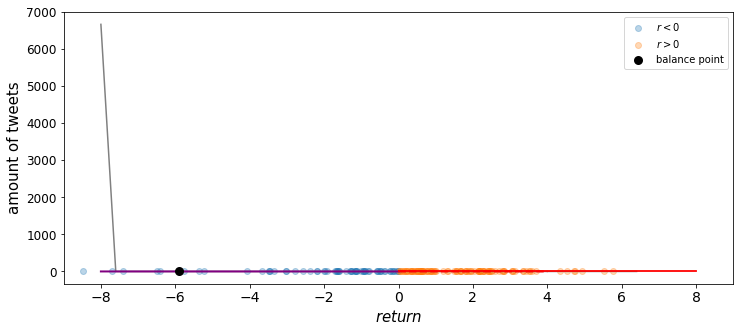

收益率为0： 15.613461867650091
收益率为1： 12.068519450222055
收益率为2： 9.020835276871665
收益率为4： 4.05021521021713
收益率为6： 0.1685715426138919


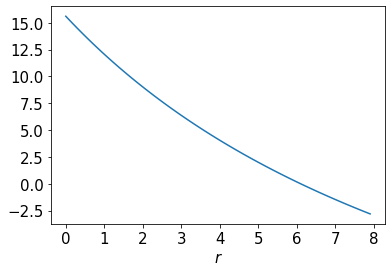

<ipython-input-2-7976d6781489>:195: RuntimeWarning: divide by zero encountered in double_scalars
  union_ratio = [union_y_n[i] / union_y[i] for i in range(len_union_x)]


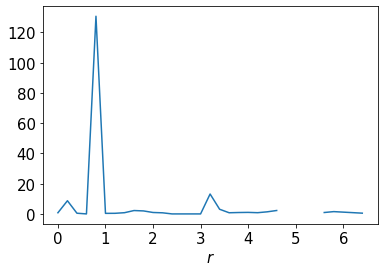

return > 0
[[Variables]]
    A1:  5.1879e-04 +/- 0.00260224 (501.59%) (init = 1000)
    A2:  0.34869106 +/- 1.70149201 (487.97%) (init = 1)
    b:   0.00109669 +/- 0.00246271 (224.56%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.996
    C(A1, A2) = -0.977
    C(A2, b)  = 0.964
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1: -0.00363878 +/- 0.03167264 (870.42%) (init = -0.00375831)
    A2:  1.01575328 +/- 4.11550635 (405.17%) (init = 1.5)
    b:   0.02280813 +/- 0.03486719 (152.87%) (init = 0.02291842)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = 0.980
    C(A1, b)  = -0.899
    C(A2, b)  = -0.838


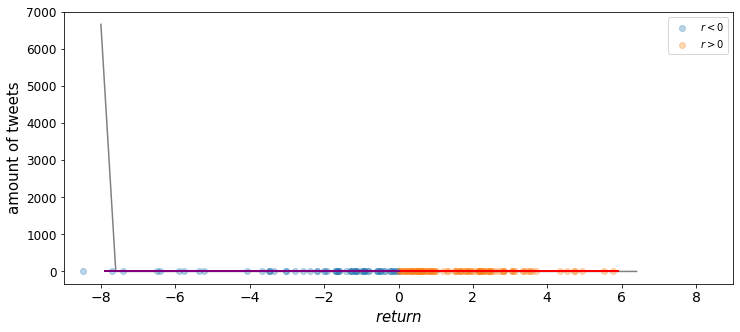

收益率为0.5： 13.967496334319483
收益率为1： 11.865993698929291
收益率为2： 8.79213933886421
收益率为4： 4.092802446791602
收益率为6： 0.16962744959793066


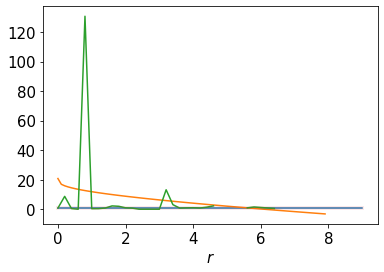

In [12]:
print("收益率与平均聚类系数")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.average_clustering[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.average_clustering[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

平均度中心性

收益率与平均度中心性
return > 0
---------- 收益率 < 0 ----------
相关性： 0.1262033384373145
参数： 0.028557881444291694 0.35119627322344643
R^2： 0.015927282632723472
[[Variables]]
    k:  0.02855788 +/- 0.02805942 (98.25%) (init = 1000)
    b:  0.35119627 +/- 0.08268273 (23.54%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： -0.09079770591992915
参数： -0.029168457056102246 0.331959699163693
R^2： 0.00824422340032216
[[Variables]]
    k: -0.02916845 +/- 0.03152262 (108.07%) (init = -1000)
    b:  0.33195970 +/- 0.06919845 (20.85%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -0.9790672639750475
平衡点： -0.3332373845194106


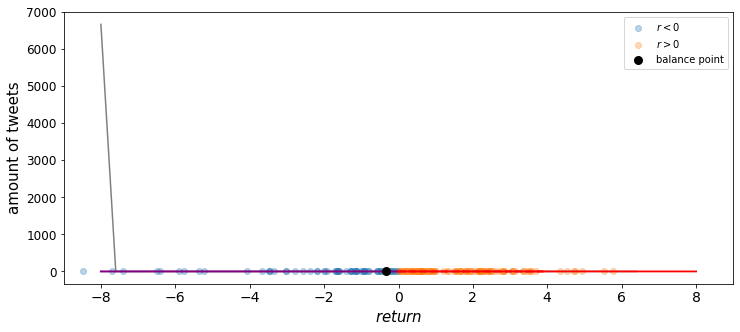

收益率为0： 1.0579485223905678
收益率为1： 1.0655473042529802
收益率为2： 1.0747661613031418
收益率为4： 1.1006980923198142
收益率为6： 1.145907486061517


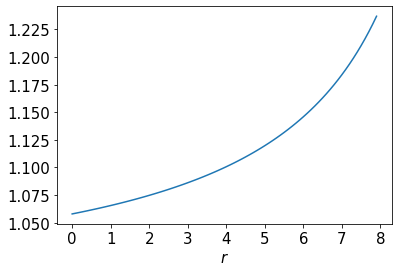

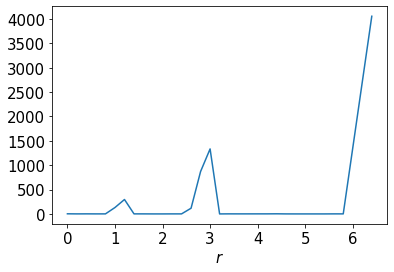

return > 0
[[Variables]]
    A1: -0.03847020 +/- 0.16584898 (431.11%) (init = 1000)
    A2:  0.84110013 +/- 2.41260275 (286.84%) (init = 1)
    b:   0.34004998 +/- 0.15546222 (45.72%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = 0.968
    C(A1, b)  = -0.946
    C(A2, b)  = -0.871
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1: -0.00198361 +/- 0.01976912 (996.62%) (init = -0.02855788)
    A2:  2.32278582 +/- 4.88746457 (210.41%) (init = 1.5)
    b:   0.31980954 +/- 0.07968710 (24.92%) (init = 0.3511963)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = 0.995
    C(A1, b)  = -0.618
    C(A2, b)  = -0.584


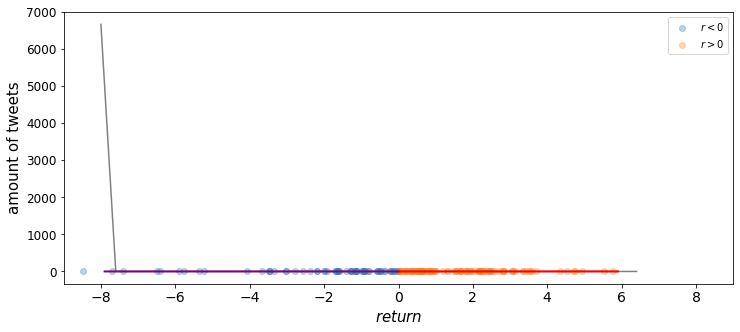

收益率为0.5： 1.0026299176728242
收益率为1： 1.0538701696706054
收益率为2： 1.1429247072557538
收益率为4： 1.2473200446558896
收益率为6： 1.156588701654294


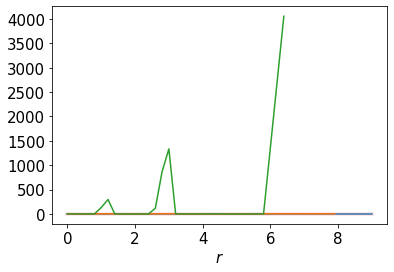

In [13]:
print("收益率与平均度中心性")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.average_degree_centrality[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.average_degree_centrality[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

PageRank得分

收益率与pagerank得分
return > 0
---------- 收益率 < 0 ----------
相关性： 0.13064168021424724
参数： 0.018741378117177472 0.29119606648716617
R^2： 0.017067248609201613
[[Variables]]
    k:  0.01874138 +/- 0.01777836 (94.86%) (init = 1000)
    b:  0.29119606 +/- 0.05238751 (17.99%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： -0.12861397693014495
参数： -0.029687781501619232 0.3494139736091695
R^2： 0.01654155506178767
[[Variables]]
    k: -0.02968778 +/- 0.02255532 (75.98%) (init = -1000)
    b:  0.34941397 +/- 0.04951343 (14.17%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -0.6312825401303658
平衡点： 1.2021250746504244


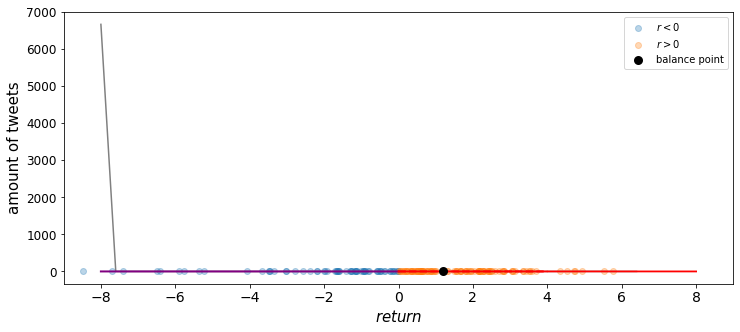

收益率为0： 0.8333841474035556
收益率为1： 0.852150043054151
收益率为2： 0.8747576216638634
收益率为4： 0.9374312173189879
收益率为6： 1.0435555575657192


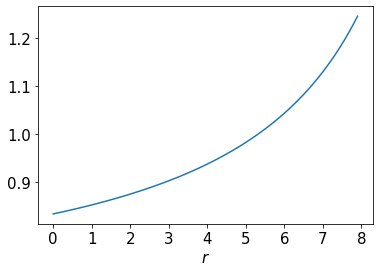

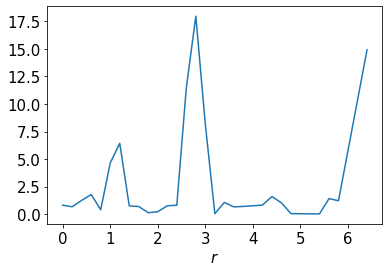

return > 0
[[Variables]]
    A1: -0.15030461 +/- 0.49881268 (331.87%) (init = 1000)
    A2:  0.29363931 +/- 0.97806966 (333.09%) (init = 1)
    b:   0.46149627 +/- 0.47740160 (103.45%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.998
    C(A1, A2) = 0.980
    C(A2, b)  = -0.972
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1: -0.05046353 +/- 0.18417783 (364.97%) (init = -0.01874138)
    A2:  0.55932189 +/- 1.45209636 (259.62%) (init = 1.5)
    b:   0.32003357 +/- 0.17447201 (54.52%) (init = 0.2911961)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.970
    C(A1, A2) = 0.966
    C(A2, b)  = -0.906


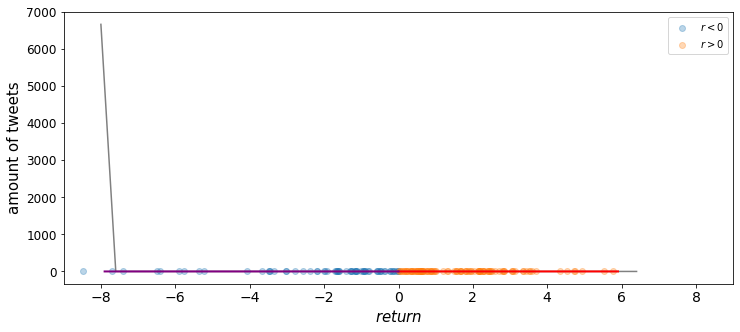

收益率为0.5： 0.8433518771166145
收益率为1： 0.8662508315624312
收益率为2： 0.8860580916290702
收益率为4： 0.8929830508635284
收益率为6： 0.8814071519649578


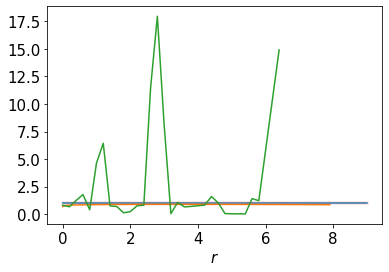

In [7]:
print("收益率与pagerank得分")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.pagerank[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.pagerank[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

平均pagerank得分

收益率与平均pagerank得分
return > 0
---------- 收益率 < 0 ----------
相关性： 0.12997722245613616
参数： 0.01854873769411807 0.2044955876245927
R^2： 0.016894078357411968
[[Variables]]
    k:  0.01854874 +/- 0.01768713 (95.35%) (init = 1000)
    b:  0.20449559 +/- 0.05211867 (25.49%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： -0.01779027638782399
参数： -0.004154751168290063 0.1889967773843831
R^2： 0.0003164939339553863
[[Variables]]
    k: -0.00415475 +/- 0.02300779 (553.77%) (init = -1000)
    b:  0.18899678 +/- 0.05050670 (26.72%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -4.464464162303136
平衡点： -0.6826620496144148


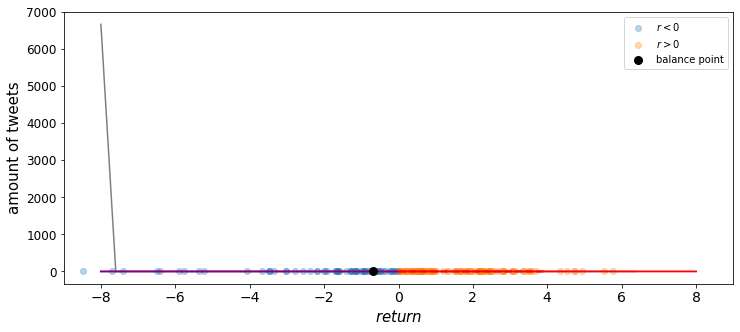

收益率为0： 1.0820056852540294
收益率为1： 1.005977124017727
收益率为2： 0.9264521377726758
收益率为4： 0.7559016153805833
收益率为6： 0.56807548008557


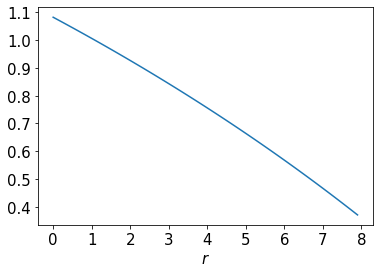

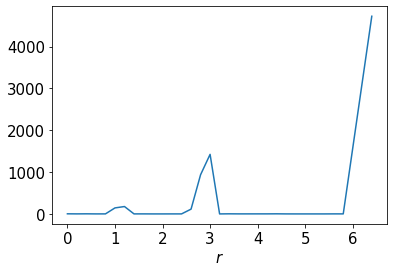

return > 0
[[Variables]]
    A1: -0.00590448 +/- 0.12631920 (2139.38%) (init = 1000)
    A2:  0.81539111 +/- 11.8438075 (1452.53%) (init = 1)
    b:   0.19062650 +/- 0.11781388 (61.80%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = 0.968
    C(A1, b)  = -0.950
    C(A2, b)  = -0.877
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1: -0.21766652 +/- 1.05078981 (482.75%) (init = -0.01854874)
    A2:  0.16323988 +/- 0.81832195 (501.30%) (init = 1.5)
    b:   0.39386689 +/- 1.02754007 (260.89%) (init = 0.2044956)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.999
    C(A1, A2) = 0.986
    C(A2, b)  = -0.983


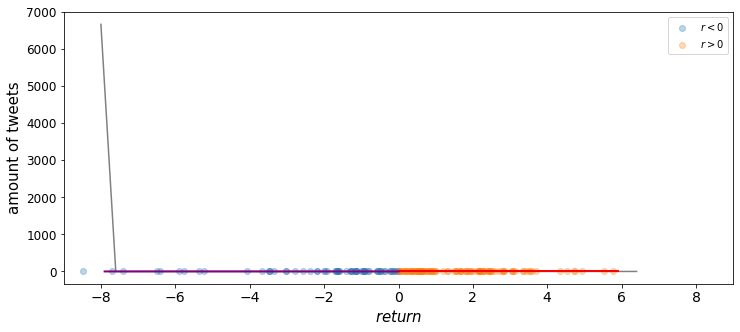

收益率为0.5： 1.0652297693515729
收益率为1： 0.9538677274558989
收益率为2： 0.8329311286493576
收益率为4： 0.70165341679911
收益率为6： 0.6190155424812196


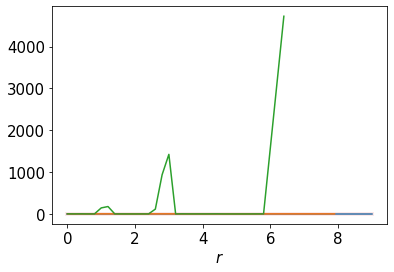

In [6]:
print("收益率与平均pagerank得分")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.average_pageRank_score[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.average_pageRank_score[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

平均最短路径长度

收益率与最短路径长度
return > 0
---------- 收益率 < 0 ----------
相关性： -0.10795714421589227
参数： -0.141198707184727 4.055349097506271
R^2： 0.011654744987251053
[[Variables]]
    k: -0.14119871 +/- 0.16253380 (115.11%) (init = 1000)
    b:  4.05534910 +/- 0.47893847 (11.81%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： 0.15573031665144646
参数： 0.33505457486609397 3.6403934320797773
R^2： 0.024251931524359782
[[Variables]]
    k:  0.33505458 +/- 0.20940769 (62.50%) (init = -1000)
    b:  3.64039343 +/- 0.45969171 (12.63%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -0.4214200246069097
平衡点： 0.8712919806864743


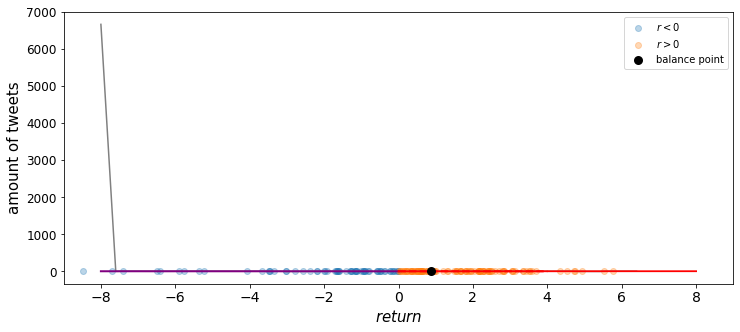

收益率为0： 1.113986488869536
收益率为1： 1.0556163223261437
收益率为2： 1.006320360456044
收益率为4： 0.9276257968441927
收益率为6： 0.8675957357687228


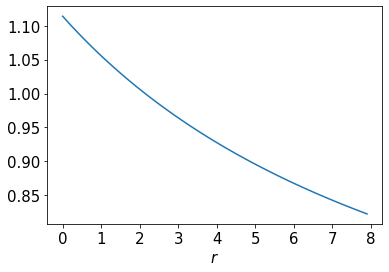

<ipython-input-2-7976d6781489>:195: RuntimeWarning: divide by zero encountered in double_scalars
  union_ratio = [union_y_n[i] / union_y[i] for i in range(len_union_x)]


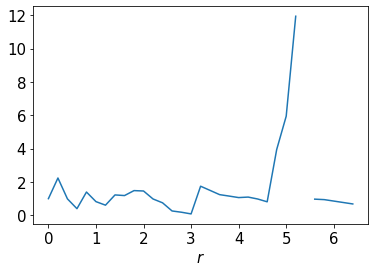

return > 0
[[Variables]]
    A1:  2.24393314 +/- 7.25237790 (323.20%) (init = 1000)
    A2:  0.22430476 +/- 0.72975080 (325.34%) (init = 1)
    b:   1.84612968 +/- 7.04879782 (381.81%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.999
    C(A1, A2) = -0.986
    C(A2, b)  = 0.983
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  0.57763220 +/- 2.44691203 (423.61%) (init = 0.1411987)
    A2:  0.41032694 +/- 1.44491137 (352.14%) (init = 1.5)
    b:   3.65551163 +/- 2.30557380 (63.07%) (init = 4.055349)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.986
    C(A1, A2) = -0.966
    C(A2, b)  = 0.931


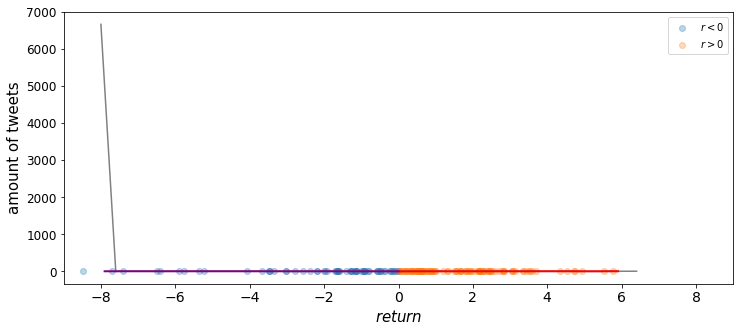

收益率为0.5： 1.085798648100591
收益率为1： 1.0349825963782955
收益率为2： 0.9900735106904772
收益率为4： 0.9525819613860815
收益率为6： 0.9346835736244103


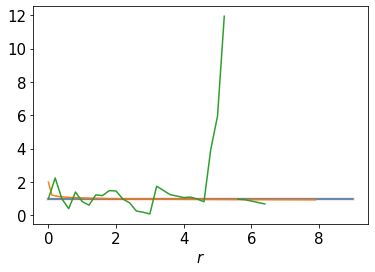

In [15]:
print("收益率与最短路径长度")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.average_shortest_path_length[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.average_shortest_path_length[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

In [ ]:
网络密度

收益率与网络密度
return > 0
---------- 收益率 < 0 ----------
相关性： 0.08885055905715175
参数： 0.018255001447298514 0.253546638514684
R^2： 0.007894421844768407
[[Variables]]
    k:  0.01825500 +/- 0.02558060 (140.13%) (init = 1000)
    b:  0.25354664 +/- 0.07537836 (29.73%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： -0.17528210765073118
参数： -0.047740879407707715 0.2692516438749669
R^2： 0.030723817262482522
[[Variables]]
    k: -0.04774088 +/- 0.02642153 (55.34%) (init = -1000)
    b:  0.26925164 +/- 0.05800054 (21.54%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -0.38237673192821964
平衡点： 0.23796947865256926


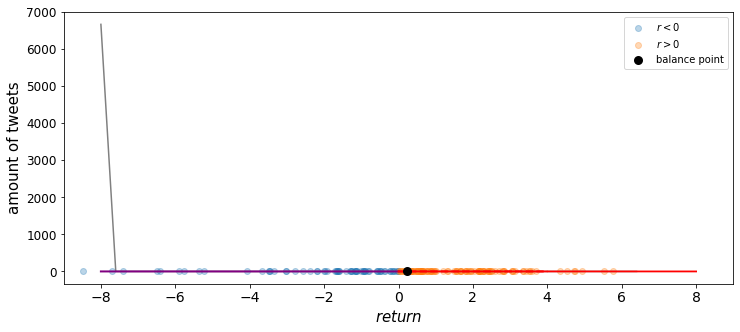

收益率为0： 0.9416716454010736
收益率为1： 1.0622131056848174
收益率为2： 1.2489887735478897
收益率为4： 2.3059260884917627
收益率为6： -8.376160723095916


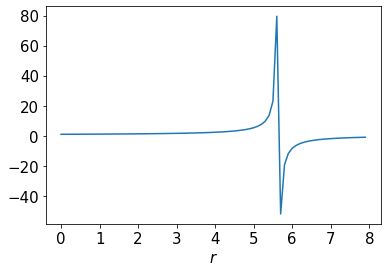

<ipython-input-2-7976d6781489>:195: RuntimeWarning: divide by zero encountered in double_scalars
  union_ratio = [union_y_n[i] / union_y[i] for i in range(len_union_x)]


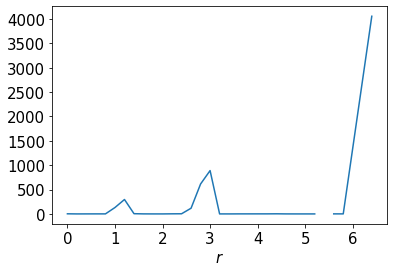

return > 0
[[Variables]]
    A1: -0.06120729 +/- 0.13594408 (222.10%) (init = 1000)
    A2:  0.85477004 +/- 1.24966337 (146.20%) (init = 1)
    b:   0.28080204 +/- 0.12780629 (45.51%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = 0.968
    C(A1, b)  = -0.944
    C(A2, b)  = -0.869
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1: -0.00868402 +/- 0.07593510 (874.42%) (init = -0.018255)
    A2:  1.36401647 +/- 4.33475517 (317.79%) (init = 1.5)
    b:   0.24399676 +/- 0.10618778 (43.52%) (init = 0.2535466)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = 0.987
    C(A1, b)  = -0.829
    C(A2, b)  = -0.777


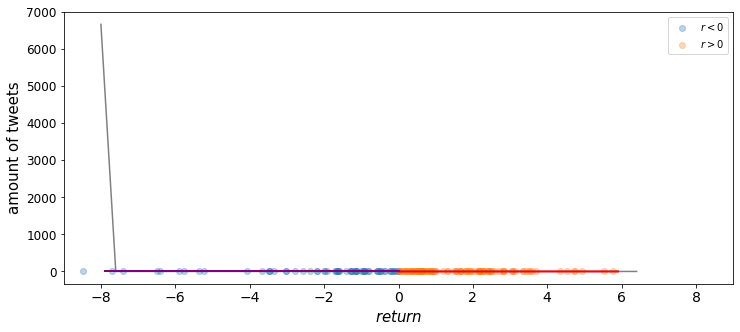

收益率为0.5： 0.9743509025642385
收益率为1： 1.0715772617071673
收益率为2： 1.3029417435374526
收益率为4： 2.3128450743103004
收益率为6： -62.585423559504996


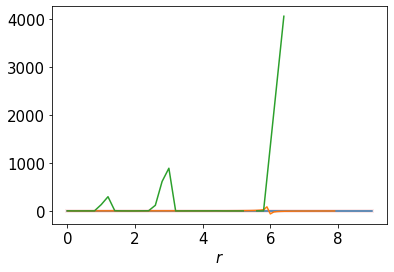

In [11]:
print("收益率与网络密度")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.sub_density[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.sub_density[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

直径

收益率与直径
return > 0
---------- 收益率 < 0 ----------
相关性： -0.15637489417259612
参数： -0.6358087571329513 10.255063331813256
R^2： 0.024453107527490858
[[Variables]]
    k: -0.63580876 +/- 0.50198827 (78.95%) (init = 1000)
    b:  10.2550633 +/- 1.47920921 (14.42%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： 0.19481590834552642
参数： 1.2474685070922824 8.615029208196747
R^2： 0.037953238144492585
[[Variables]]
    k:  1.24746851 +/- 0.61884894 (49.61%) (init = -1000)
    b:  8.61502921 +/- 1.35849704 (15.77%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -0.509679205140781
平衡点： 0.8708405048850876


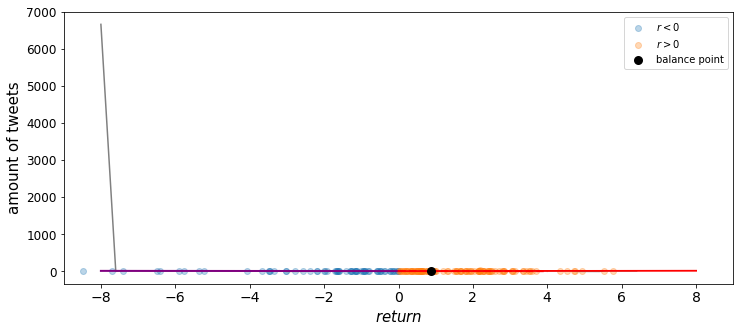

收益率为0： 1.1903689568522997
收益率为1： 1.1042711900518845
收益率为2： 1.037508180975237
收益率为4： 0.9407121930824981
收益率为6： 0.8739164895723199


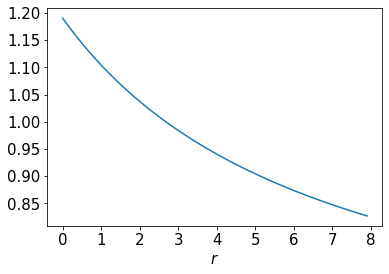

<ipython-input-2-7976d6781489>:195: RuntimeWarning: divide by zero encountered in double_scalars
  union_ratio = [union_y_n[i] / union_y[i] for i in range(len_union_x)]


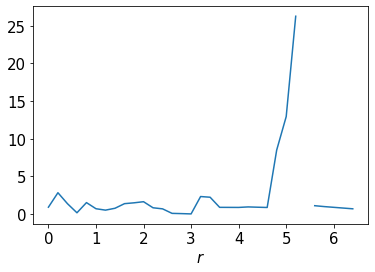

return > 0
[[Variables]]
    A1:  4.80044769 +/- 9.94816191 (207.23%) (init = 1000)
    A2:  0.36851555 +/- 0.71743437 (194.68%) (init = 1)
    b:   5.37222387 +/- 9.38644883 (174.72%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.995
    C(A1, A2) = -0.976
    C(A2, b)  = 0.961
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  1.40050971 +/- 4.42222723 (315.76%) (init = 0.6358088)
    A2:  0.64224504 +/- 1.32592251 (206.45%) (init = 1.5)
    b:   9.55648113 +/- 4.24291130 (44.40%) (init = 10.25506)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.969
    C(A1, b)  = -0.959
    C(A2, b)  = 0.893


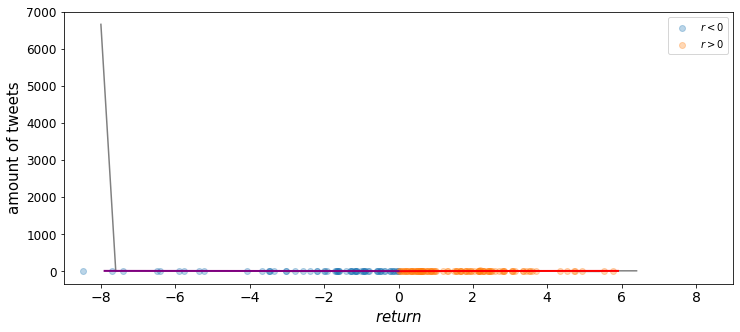

收益率为0.5： 1.1499643694922046
收益率为1： 1.077100619618027
收益率为2： 1.0149199195031322
收益率为4： 0.9696958592192207
收益率为6： 0.9536292456872265


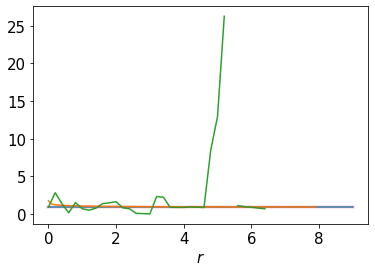

In [12]:
print("收益率与直径")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.diameter[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.diameter[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

节点数量

收益率与节点数量
return > 0
---------- 收益率 < 0 ----------
相关性： -0.43777771228540385
参数： -1640.5449645200001 4924.8935481168955
R^2： 0.1916493253738416
[[Variables]]
    k: -1640.54496 +/- 421.157369 (25.67%) (init = 1000)
    b:  4924.89355 +/- 1241.02475 (25.20%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： 0.2259300543710108
参数： 1134.5555522208708 3883.903698962473
R^2： 0.051044389468087537
[[Variables]]
    k:  1134.55555 +/- 482.010052 (42.48%) (init = -1000)
    b:  3883.90370 +/- 1058.10835 (27.24%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.445980288324062
平衡点： 0.375117889559179


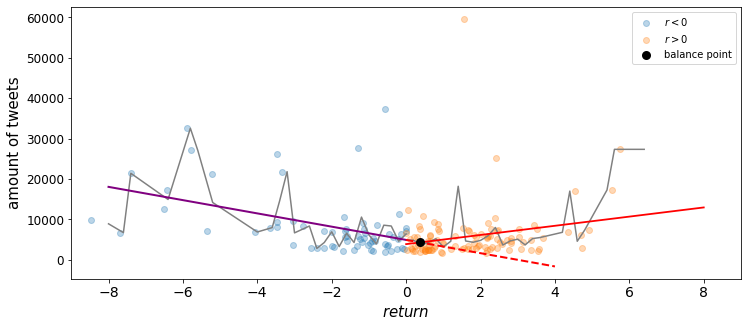

收益率为0： 1.2680266890841057
收益率为1： 1.3082578106196194
收益率为2： 1.3336524840825765
收益率为4： 1.3639161337514167
收益率为6： 1.3813334526457028


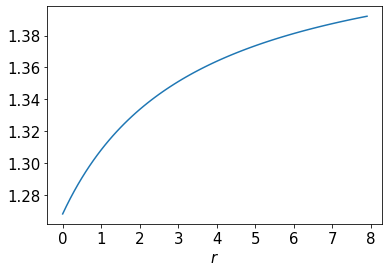

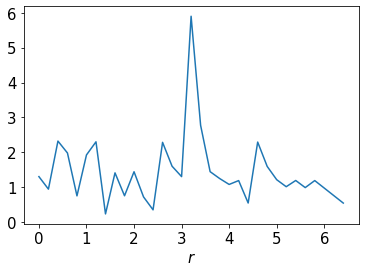

return > 0
[[Variables]]
    A1:  3.2836e-06 +/- 4.6536e-05 (1417.21%) (init = 1000)
    A2:  12.9049608 +/- 8.09884592 (62.76%) (init = 1)
    b:   5471.71577 +/- 633.209495 (11.57%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.197
    C(A2, b)  = 0.194
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  1482.30462 +/- 1974.76460 (133.22%) (init = 1640.545)
    A2:  1.04915740 +/- 0.63119744 (60.16%) (init = 1.5)
    b:   5073.59591 +/- 2212.25056 (43.60%) (init = 4924.894)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.981
    C(A1, b)  = -0.893
    C(A2, b)  = 0.833


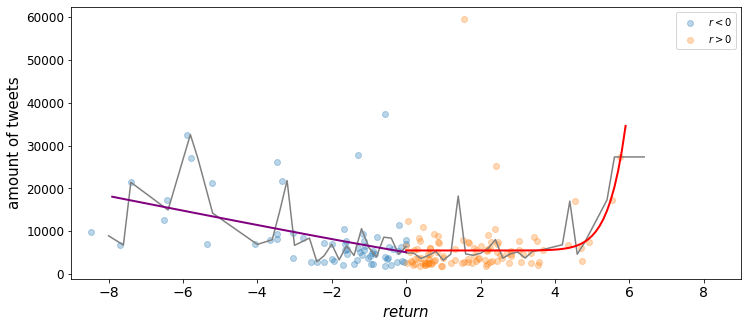

收益率为0.5： 1.0581543965906723
收益率为1： 1.1981434724895463
收益率为2： 1.4878189501696912
收益率为4： 2.0161003334812007
收益率为6： 0.35507148639672187


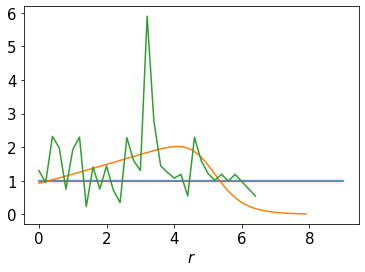

In [6]:
print("收益率与节点数量")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.number_of_nodes[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.number_of_nodes[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

子图的节点数量

收益率与子图的节点数量
return > 0
---------- 收益率 < 0 ----------
相关性： -0.3028429662403142
参数： -988.5322358311493 1759.0642310157518
R^2： 0.0917138622012319
[[Variables]]
    k: -988.532236 +/- 388.861281 (39.34%) (init = 1000)
    b:  1759.06423 +/- 1145.85784 (65.14%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： 0.14306068943987713
参数： 662.5528446408867 1003.8848223056623
R^2： 0.02046636086301279
[[Variables]]
    k:  662.552845 +/- 451.638833 (68.17%) (init = -1000)
    b:  1003.88482 +/- 991.437445 (98.76%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.4920051190285781
平衡点： 0.45738370338504175


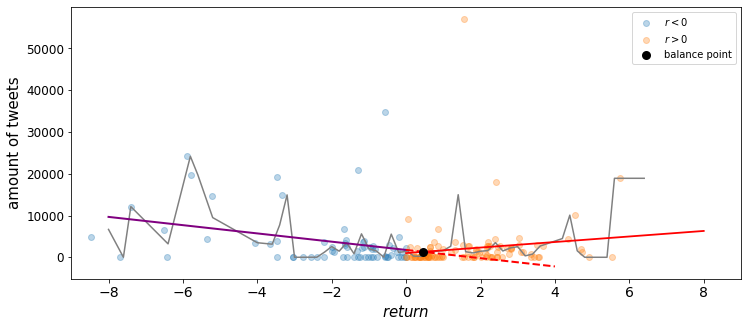

收益率为0： 1.7522570238442683
收益率为1： 1.6487844228109554
收益率为2： 1.6041837371555074
收益率为4： 1.5635037668086946
收益率为6： 1.5444759653578655


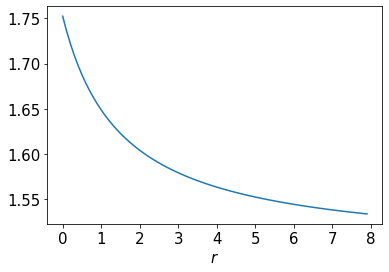

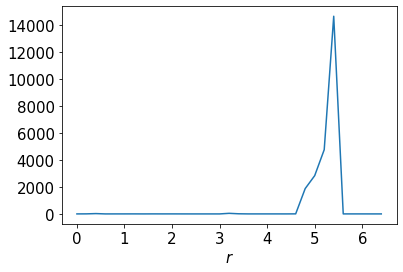

return > 0
[[Variables]]
    A1:  2.5635e-91 (init = 1000)
    A2:  124.691534 (init = 1)
    b:   2002.45177 (init = 4000)
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  1277.75241 +/- 2337.01079 (182.90%) (init = 988.5322)
    A2:  0.87868422 +/- 0.83781538 (95.35%) (init = 1.5)
    b:   1490.41350 +/- 2409.24038 (161.65%) (init = 1759.064)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.976
    C(A1, b)  = -0.923
    C(A2, b)  = 0.859


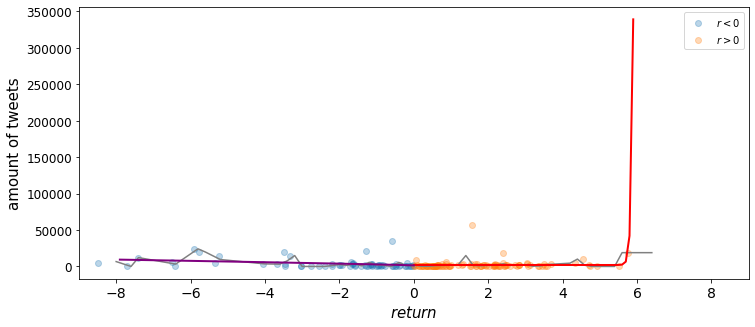

收益率为0.5： 1.0913301758968668
收益率为1： 1.3823883049587444
收益率为2： 1.9175561854416905
收益率为4： 2.901568077580667
收益率为6： 0.002793531694779174


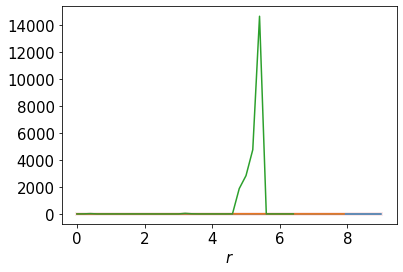

In [7]:
print("收益率与子图的节点数量")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.number_of_nodes_for_largest_subgraph[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.number_of_nodes_for_largest_subgraph[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

子图边数

收益率与子图的边数
return > 0
---------- 收益率 < 0 ----------
相关性： -0.3233979442143853
参数： -1198.1289582176735 1799.5665893871737
R^2： 0.10458623032209047
[[Variables]]
    k: -1198.12896 +/- 438.215981 (36.58%) (init = 1000)
    b:  1799.56659 +/- 1291.29137 (71.76%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： 0.16288932709371934
参数： 784.8170278929863 953.9742895257227
R^2： 0.026532932881044857
[[Variables]]
    k:  784.817028 +/- 468.400995 (59.68%) (init = -1000)
    b:  953.974290 +/- 1028.23374 (107.78%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.526634764072734
平衡点： 0.42643234146785386


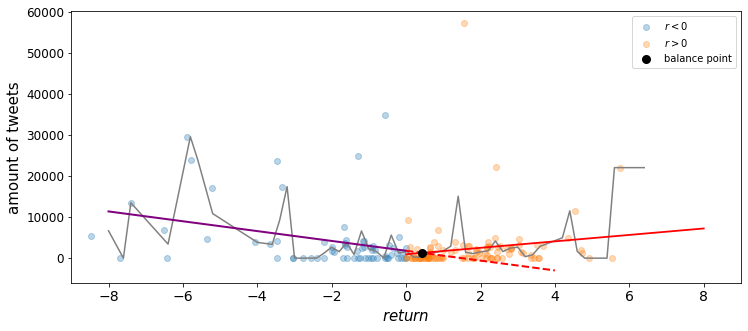

收益率为0： 1.8863889825393987
收益率为1： 1.7240111090818082
收益率为2： 1.662629034183308
收益率为4： 1.6104793648404736
收益率为6： 1.5872393486118228


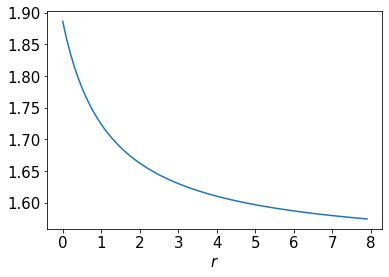

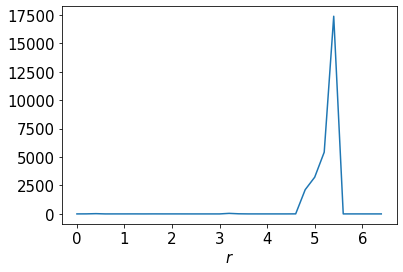

return > 0
[[Variables]]
    A1:  1.7983e-90 (init = 1000)
    A2:  123.672955 (init = 1)
    b:   2137.82332 (init = 4000)
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  1660.48159 +/- 2752.55584 (165.77%) (init = 1198.129)
    A2:  0.84663182 +/- 0.75760336 (89.48%) (init = 1.5)
    b:   1370.76597 +/- 2804.40910 (204.59%) (init = 1799.567)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.975
    C(A1, b)  = -0.928
    C(A2, b)  = 0.863


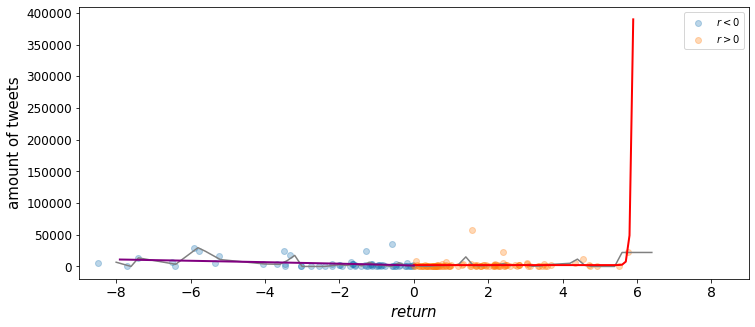

收益率为0.5： 1.0731144177000989
收益率为1： 1.417913043180223
收益率为2： 2.0379635959851923
收益率为4： 3.1529990387697846
收益率为6： 0.0028834515143300416


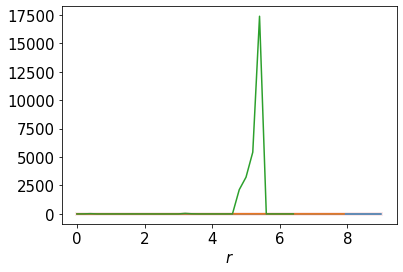

In [8]:
print("收益率与子图的边数")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.number_of_edges_for_largest_subgraph[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.number_of_edges_for_largest_subgraph[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

平均度

收益率与平均度
return > 0
---------- 收益率 < 0 ----------
相关性： -0.4802273380121332
参数： -0.02796273159699859 1.8070776248005596
R^2： 0.23061829617421914
[[Variables]]
    k: -0.02796273 +/- 0.00638431 (22.83%) (init = 1000)
    b:  1.80707762 +/- 0.01881264 (1.04%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： 0.2474584062570608
参数： 0.016292459712080373 1.7932387378509649
R^2： 0.06123566282728443
[[Variables]]
    k:  0.01629246 +/- 0.00628556 (38.58%) (init = -1000)
    b:  1.79323874 +/- 0.01379806 (0.77%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.716298956152401
平衡点： 0.31270652188448733


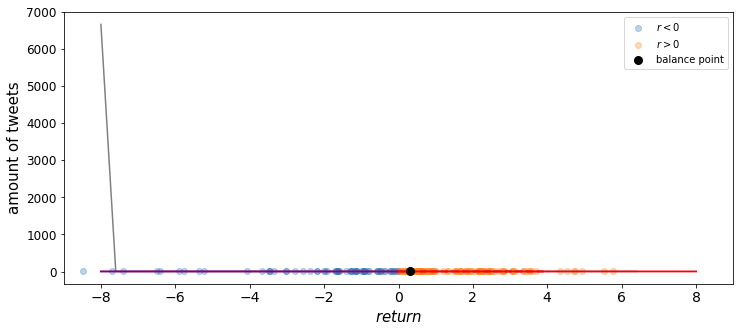

收益率为0： 1.007717258532001
收益率为1： 1.0140971091677595
收益率为2： 1.0203631005498734
收益率为4： 1.032565483848959
收益率为6： 1.0443473329924289


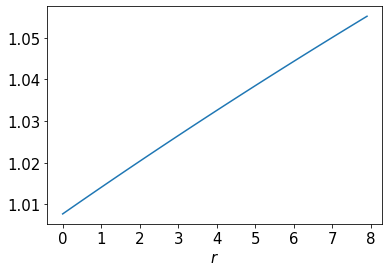

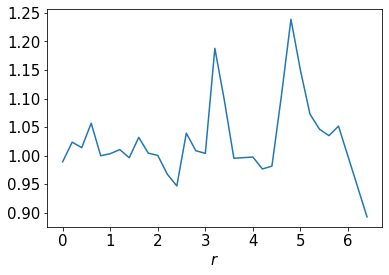

return > 0
[[Variables]]
    A1:  1.3268e-18 +/- 4.0534e-17 (3055.01%) (init = 1000)
    A2:  22.8309279 +/- 17.1532924 (75.13%) (init = 1)
    b:   1.81756712 +/- 0.00815680 (0.45%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.113
    C(A2, b)  = 0.112
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  0.07946552 +/- 0.06826036 (85.90%) (init = 0.02796273)
    A2:  0.54075510 +/- 0.33666856 (62.26%) (init = 1.5)
    b:   1.76004080 +/- 0.06453905 (3.67%) (init = 1.807078)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -0.972
    C(A1, A2) = -0.966
    C(A2, b)  = 0.909


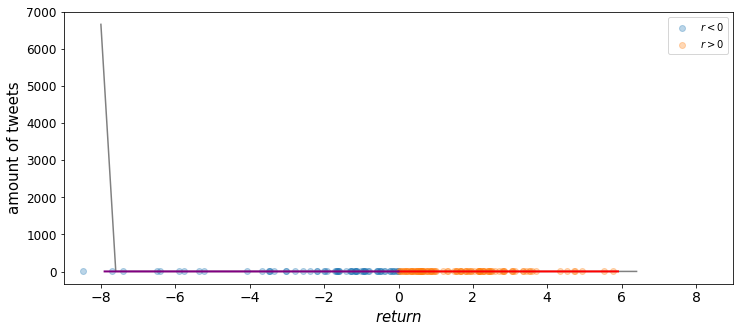

收益率为0.5： 0.998403994607878
收益率为1： 1.0120706394171088
收益率为2： 1.0319519683926093
收益率为4： 1.060830900502606
收益率为6： 0.7599494434873726


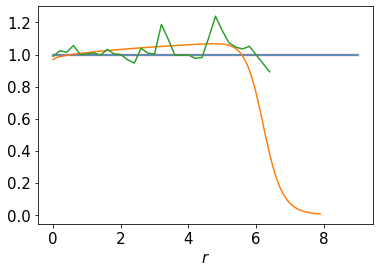

In [6]:
print("收益率与平均度")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.average_degree[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.average_degree[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

最大子图平均度

收益率与最大子图的平均度
return > 0
---------- 收益率 < 0 ----------
相关性： -0.07919719195336526
参数： -0.020711118402436286 1.9991093301551874
R^2： 0.006272195213298359
[[Variables]]
    k: -0.02071112 +/- 0.03258648 (157.34%) (init = 1000)
    b:  1.99910933 +/- 0.09602262 (4.80%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： 0.2438065710681118
参数： 0.06690524110431059 1.8233814598238687
R^2： 0.059441644095990176
[[Variables]]
    k:  0.06690524 +/- 0.02622340 (39.19%) (init = -1000)
    b:  1.82338146 +/- 0.05756560 (3.16%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -0.30955898313177
平衡点： 2.0056513568996994


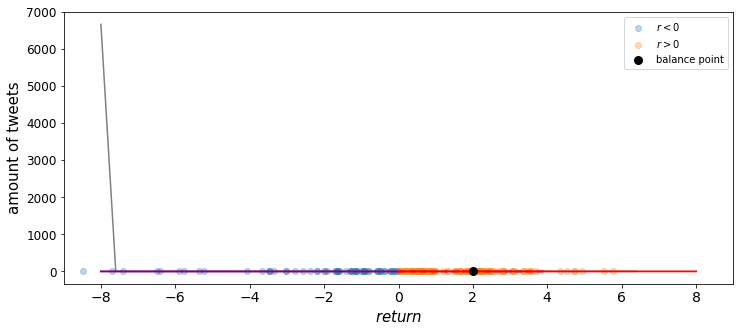

收益率为0： 1.09637471598965
收益率为1： 1.0685259794537199
收益率为2： 1.0425812221774344
收益率为4： 0.9956725920681501
收益率为6： 0.9544065635425516


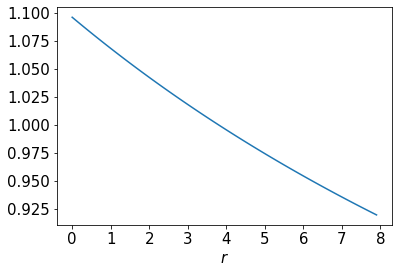

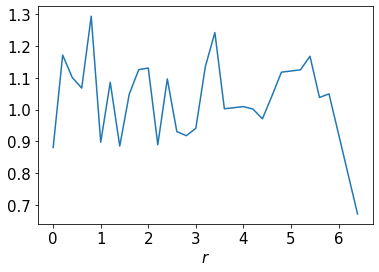

return > 0
[[Variables]]
    A1:  0.07715629 +/- 0.12302144 (159.44%) (init = 1000)
    A2:  0.91503853 +/- 0.91276798 (99.75%) (init = 1)
    b:   1.81466212 +/- 0.11736947 (6.47%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.969
    C(A1, b)  = -0.934
    C(A2, b)  = 0.856
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  1040.13798 +/-        nan (nan%) (init = 0.02071112)
    A2:  6.8586e-05 +/-        nan (nan%) (init = 1.5)
    b:  -1038.10713 +/-        nan (nan%) (init = 1.999109)


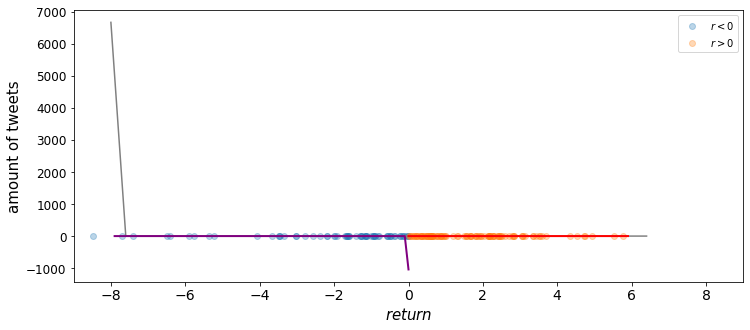

收益率为0.5： 1.0678092427072279
收益率为1： 1.0734926169736494
收益率为2： 1.0612979410837848
收益率为4： 1.0195110798970952
收益率为6： 0.9757957196646285


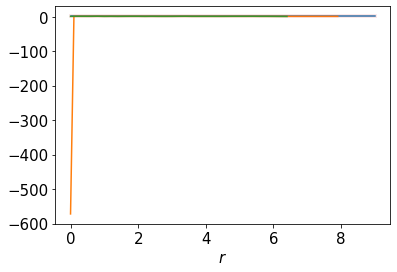

In [7]:
print("收益率与最大子图的平均度")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.average_degree_sub[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.average_degree_sub[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

将最大节点的影响力值作为每天的网络影响力

ci-max

收益率与最大节点的CI值
return > 0
---------- 收益率 < 0 ----------
相关性： -0.07336933728991095
参数： -269468.38545685855 1649528.1003565174
R^2： 0.005383059654360922
[[Variables]]
    k: -269468.375 +/- 457858.381 (169.91%) (init = 1000)
    b:  1649528.15 +/- 1349171.65 (81.79%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： 0.028887855413066398
参数： 200919.09913065526 956452.3378941065
R^2： 0.0008345081903663454
[[Variables]]
    k:  200919.821 +/- 685024.363 (340.94%) (init = -1000)
    b:  956451.148 +/- 1503765.32 (157.22%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.3411785471008235
平衡点： 1.4734145468818627


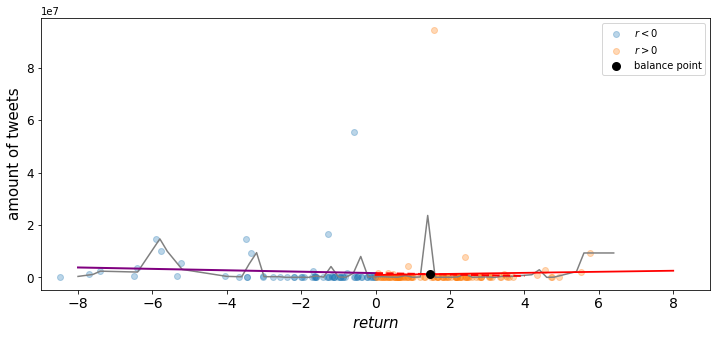

收益率为0： 1.7246317824769064
收益率为1： 1.6580644937519047
收益率为2： 1.6111905465119343
收益率为4： 1.5495466830656337
收益率为6： 1.5108179333028189


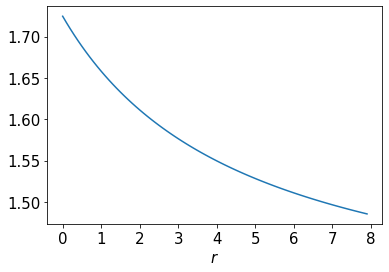

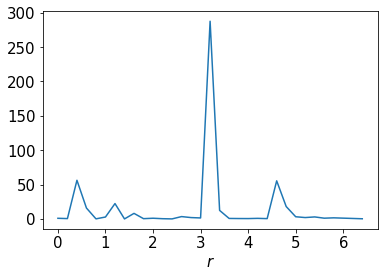

return > 0
[[Variables]]
    A1:  3.3370e-30 +/- 1.1744e-27 (35193.16%) (init = 1000)
    A2:  47.8476722 +/- 201.081612 (420.25%) (init = 1)
    b:   1220249.26 +/- 916835.688 (75.14%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  219507.150 +/- 2002872.93 (912.44%) (init = 269468.4)
    A2:  1.09991701 +/- 4.33702754 (394.30%) (init = 1.5)
    b:   1696711.23 +/- 2308155.30 (136.04%) (init = 1649528)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.982
    C(A1, b)  = -0.884
    C(A2, b)  = 0.825


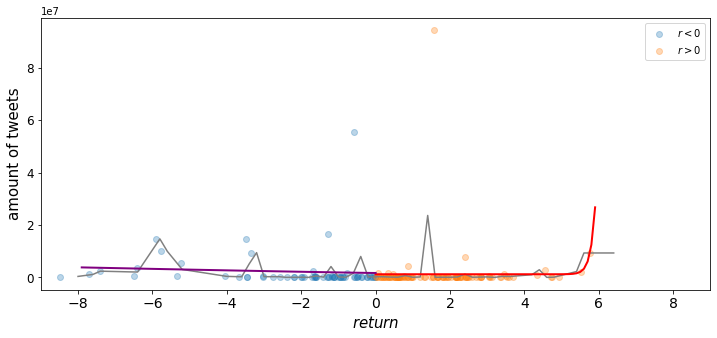

收益率为0.5： 1.4743879619000628
收益率为1： 1.5703499562784118
收益率为2： 1.7760371625544271
收益率为4： 2.2169115918617504
收益率为6： 0.056172975318875114


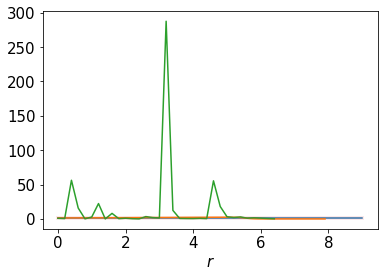

In [10]:
print("收益率与最大节点的CI值")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.ci[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.ci[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

ci_global

收益率与十个节点的CI值之和
return > 0
---------- 收益率 < 0 ----------
相关性： -0.2807287269027055
参数： -2258553.363712416 1410925.9738328904
R^2： 0.07880861810841377
[[Variables]]
    k: -2258553.39 +/- 965224.727 (42.74%) (init = 1000)
    b:  1410925.90 +/- 2844228.46 (201.59%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.721
---------- 收益率 > 0 ----------
相关性： 0.1541407887253008
参数： 1196159.9741677833 42969.03000764735
R^2： 0.023759382748857694
[[Variables]]
    k:  1196159.18 +/- 755495.064 (63.16%) (init = -1000)
    b:  42971.4628 +/- 1658462.14 (3859.45%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.798
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.888169987700669
平衡点： 0.3959682931796063


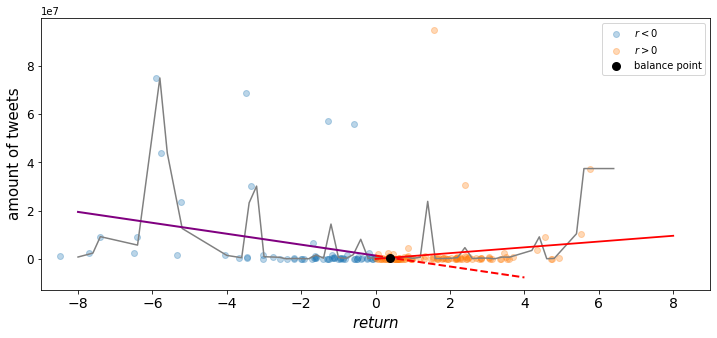

收益率为0： 32.83588141463242
收益率为1： 2.9613376211681324
收益率为2： 2.4342214636435906
收益率为4： 2.1636258419690244
收益率为6： 2.0723536775945948


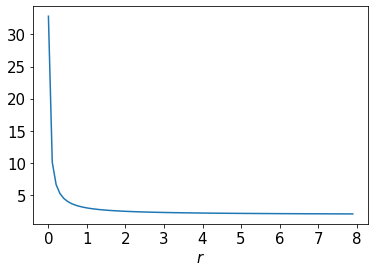

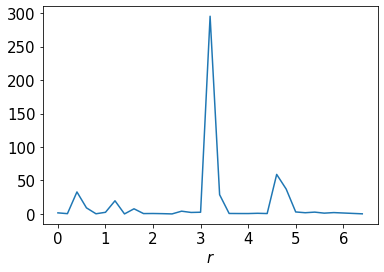

return > 0
[[Variables]]
    A1:  1.5597e-19 +/- 7.8910e-18 (5059.34%) (init = 1000)
    A2:  34.6644639 +/- 28.4029160 (81.94%) (init = 1)
    b:   1712933.12 +/- 963820.657 (56.27%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  4307998.72 +/- 7566925.80 (175.65%) (init = 2258553)
    A2:  0.70645398 +/- 0.76492021 (108.28%) (init = 1.5)
    b:  -485725.607 +/- 7369107.78 (1517.13%) (init = 1410926)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.971
    C(A1, b)  = -0.950
    C(A2, b)  = 0.883


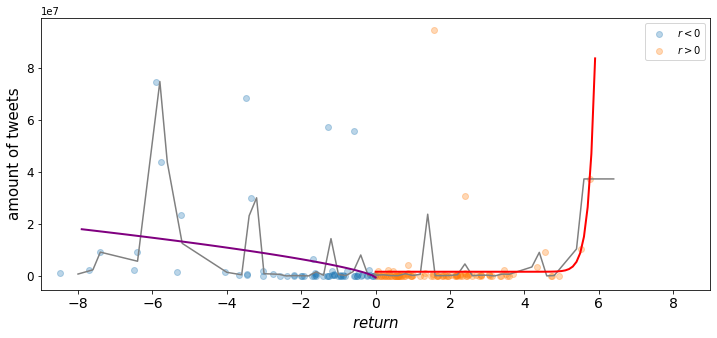

收益率为0.5： 1.2576800435076478
收益率为1： 2.231419936252199
收益率为2： 3.8203573922962697
收益率为4： 6.41273414970366
收益率为6： 0.09947204756653535


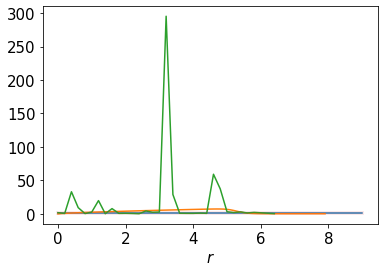

In [11]:
print("收益率与十个节点的CI值之和")
x_n = olhc_6.close[olhc_6.close<0]
y_n = olhc_6.ci_sum[olhc_6.close<0]
x = olhc_6.close[olhc_6.close>0]
y = olhc_6.ci_sum[olhc_6.close>0]
my_analysis(x_n, y_n, x, y, hi='Kay')

pass